# Simulating fly-bys

This notebook will take you through a simulation of fly-bys of a star perturbing a planetary system.

### Imports

In [1]:
import rebound
import numpy as np
from scipy import spatial

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [85]:
import pickle

In [79]:
with open('sim_results_i0.pickle', 'wb') as handle:
    pickle.dump(results, handle)

In [80]:
results

[{'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1090.2273526322256],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1011.0826108972403],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1069.013744923368],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1069.5424735605038],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1318.2226662217256, 1338.2226662217256, 1938.2226662217256],
  'v_escapes': [1048.2226662217256,
   1058.2226662217256,
   1068.2226662217256,
   1078.2226662217256,
   1088.2226662217256,
   1098.22266622172

### Setup
Let's first create a simulation of our target planetary system. We'll use Sun and the outer planets of our solar system for now. Using NASA Horizons database to get the details of each object.

In [2]:
sim = rebound.Simulation()
particle_names = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune"]
# we use the NASA horizon database to look up the Sun and planets
sim.add(particle_names)

# let's give all the particles a unique hash (based on its name)
for i, particle in enumerate(sim.particles):
    particle.hash = particle_names[i]

sim.status()
    

Searching NASA Horizons for 'Sun'... 

KeyboardInterrupt: 

Let's save this simulation for future reference.

In [6]:
sim.save("solar_system_outer_planets.bin")

In [22]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
sim.integrate(10**6)
sim.status()

---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0000000000000000e+06
Current timestep:    	1.922840
---------------------------------
<rebound.Particle object, m=1.0 x=1.8571023142313239 y=4.505158999518282 z=0.05579575801210394 vx=0.00010973285292743885 vy=-0.0004353304883274691 vz=2.066748558783543e-06>
<rebound.Particle object, m=0.0009547919152112404 x=6.8147702502840595 y=6.73118953776824 z=-0.07725869827938392 vx=-0.17315013118184355 vy=0.38141414608509566 vz=-0.00032924316529987395>
<rebound.Particle object, m=0.0002858856727222417 x=9.322714404062348 y=-0.8332873658381746 z=-0.24580494591406266 vx=0.21018085977735299 vy=0.2627479070254194 vz=-0.006398792605082137>
<rebound.Particle object, m=4.36624373583127e-05 x=-15.44022591324002 y=13.728660728813322 z=0.2217606828122171 vx=-0.1069942017683012 vy=-0.1960591412410102 vz=0.008071389951229656>
<re

Let's define a function that simulates a single fly-by given a certain system and a particle that will be intruding the system.

In [2]:
def simulate_fly_by(sim, intruder, sim_results, visualize=False):
    
    intruder.hash = "intruder"
    sim.add(intruder)
    
    intruder_distance = np.linalg.norm(sim.particles["intruder"].xyz)
    sim.exit_max_distance = intruder_distance*1.01
    
    while True:
        try:
            sim.integrate(sim.t+10)
            
            test_sim = sim.copy()
            test_sim.remove(hash="intruder")
            if check_immediate_ejection(test_sim):
                sim_results["v_escapes"].append(sim.t)
            
            if check_orbit_crossing(test_sim):
                sim_results["orbit_crossing"].append(sim.t)

            if check_kozai(test_sim):
                sim_results["kozai"].append(sim.t)
            
            if visualize:
                fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]")
                display(fig)
                plt.close(fig)
                clear_output(wait=True)

        except rebound.Escape as error:
            if type(rebound.Escape()) == type(error):
                print("joe")
            # remove intruder
            sim.remove(hash="intruder")
            sim.move_to_com()
                    
            return sim


In [3]:
def evolve_system(sim, t, sim_results):
    sim.exit_max_distance = 500
    
    close_encounters = []
    ejections = []
    # set planet radii to their hill spheres
    for planet in sim.particles[1:]:
        planet.r = planet.rhill
        
    sim.collision = "direct"
    
    end_time = sim.t + t
    while sim.t < end_time:
        try:
            sim.integrate(sim.t + 10)
            
            if check_immediate_ejection(sim):
                sim_results["v_escapes"].append(sim.t)
            
            if check_orbit_crossing(sim.copy()):
                sim_results["orbit_crossing"].append(sim.t)

            if check_kozai(sim):
                sim_results["kozai"].append(sim.t)
            
        except (rebound.Collision, rebound.Escape) as error:
            #sim.status()
            if type(error) == type(rebound.Collision()):
                print(error, sim.t)
                collided = []
                for particle in sim.particles:
                    if particle.lastcollision == sim.t:
                        collided.append(particle.index)
                
                planet_1 = sim.particles[collided[0]]
                planet_2 = sim.particles[collided[1]]
                
                d = np.linalg.norm(np.array(planet_1.xyz) - np.array(planet_2.xyz))
                print(planet_1.index, planet_2.index, "close encounter. distance:", d)
            
                resolve_collision(sim)
                close_encounters.append(((planet_1.index, planet_2.index), d, sim.t))
                sim_results["close_encounters"].append(sim.t)
            
            else:
                print(error)
                out_of_bounds = []
                for i, particle in enumerate(sim.particles):
                    distance = np.linalg.norm(particle.xyz)
                    if distance > sim.exit_max_distance:
                        print("Removed", particle.index, str(particle.hash))
                        out_of_bounds.append(particle.hash)
                        ejections.append((particle.index, particle.xyz, sim.t))
                
                for hsh in out_of_bounds:
                        sim.remove(hash=hsh)
                        sim.move_to_com()
                        
                sim_results["escapes"].append(sim.t)
                        
    return (sim, close_encounters, ejections, sim_results)
    

In [4]:
def resolve_collision(sim):
    while True:
        try:
            sim.integrate(sim.t+0.1)
            return
        except:
            #  integrate one step without collision detection
            sim.collision = "none"
            sim.step()
            sim.collision = "direct"
            

In [8]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.0,x=30.6,y=-1000.,vy=2.)
sim = simulate_fly_by(sim, intruder)

evolve_system(sim, 10**7)

joe


In [29]:
sim = rebound.Simulation.from_file("random_sims/solar_system_outer_planets_5788.bin")
for particle in sim.particles:
    print(particle.hash)
    
sim.status()

c_uint(3000342645)
c_uint(3586273463)
c_uint(4066125545)
c_uint(516400076)
c_uint(1470785325)
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	2.9558356028911448e+05
Current timestep:    	1.791724
---------------------------------
<rebound.Particle object, m=1.0 x=0.790392015242414 y=1.2800362480961802 z=0.010029648972591659 vx=-0.00042033941518836116 vy=0.000129634499445474 vz=1.1512510585973728e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-1.62321457248114 y=-3.5400958261243316 z=0.07831235094641473 vx=0.37710694334404987 vy=-0.19041810608900203 vz=-0.008487860358737817>
<rebound.Particle object, m=0.0002858856727222417 x=7.393583393592568 y=-6.584560782884102 z=-0.07737077919291399 vx=0.22619076558664736 vy=0.1970974490642162 vz=-0.012280195894553527>
<rebound.Particle object, m=4.36624373583127e-05 x=20.285578703970426 y=5.068961369614927 z=-

In [ ]:
total_simulations = 100
max_evolve_time = 10**5
a_list = np.linspace(0, 100, total_simulations)

results = []


close_encounter_times = []
ejection_times = []

for sim_n in range(total_simulations):
    print(sim_n)
    
    sim_results = get_sim_results_dict()
    random_sim = rebound.Simulation.from_file("random_sims/solar_system_outer_planets_{:04d}.bin".format(np.random.randint(0,10**4)))
    random_sim.t = 0
    sim_results["sim"] = random_sim
    
    intruder = rebound.Particle(m=1.0, x=a_list[sim_n], y=-1000., vy=2.)
    # save a copy of the intruder in sim_results
    sim_results["intruder"] = intruder.copy()
    
    sim = simulate_fly_by(random_sim, intruder, sim_results, visualize=False)
    sim.status()
    sim_results["stable_after_fly_by"] = analyze_stability(sim)
    sim.status()
    result = evolve_system(sim, max_evolve_time, sim_results)
    sim, close_encounters, ejections, sim_results = result
    
    results.append(sim_results)
    
    if close_encounters:
        close_encounter_times.append(close_encounters[0][-1])
        
    if ejection_times:
        ejection_times.append(ejections[0][-1])
        
close_encounter_times.sort()   
fraction_encounters = np.arange(1, len(close_encounter_times) + 1) / total_simulations

ejection_times.sort()
fraction_ejections = np.arange(1, len(ejection_times) + 1) / total_simulations
    
    

0
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.1600000000000000e+03
Current timestep:    	5.288376
---------------------------------
<rebound.Particle object, m=1.0 x=-1.302067967981202 y=0.6825807619088664 z=0.008706524974355645 vx=-0.001969228799015177 vy=0.0010224744364636384 vz=1.3205108496214257e-05>
<rebound.Particle object, m=0.0009547919152112404 x=1072.9310951275093 y=-542.0186160785306 z=-7.77384437800724 vx=1.6233116285532228 vy=-0.8091398812993855 vz=-0.011810531684319649>
<rebound.Particle object, m=0.0002858856727222417 x=777.2966299002221 y=-458.8494808137186 z=-9.513680130998294 vx=1.186813079391269 vy=-0.6934592193300186 vz=-0.014729523876066283>
<rebound.Particle object, m=4.36624373583127e-05 x=630.2580863656945 y=-362.247462867682 z=8.545498900849577 vx=0.919995861344838 vy=-0.5408479215495469 vz=0.013189432035078356>
<rebound.P

A particle escaped (r>exit_max_distance).
Removed 4 c_uint(1470785325)
A particle escaped (r>exit_max_distance).
Removed 3 c_uint(516400076)
A particle escaped (r>exit_max_distance).
Removed 2 c_uint(4066125545)
4
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0100000000000000e+03
Current timestep:    	5.134403
---------------------------------
<rebound.Particle object, m=1.0 x=1.0330440722685807 y=-0.30324920039680237 z=-0.09195785571595816 vx=0.0020255186223503974 vy=-0.0005813636216803475 vz=-0.0001797403485239162>
<rebound.Particle object, m=0.0009547919152112404 x=-848.0426971105308 y=283.6385879700145 z=90.39953090548723 vx=-1.664149076724749 vy=0.5507096891744916 vz=0.17665039513852643>
<rebound.Particle object, m=0.0002858856727222417 x=-704.7631252085251 y=128.88079853437688 z=18.832135035564402 vx=-1.389601849189838 vy=0.2368149267941686 vz

A particle escaped (r>exit_max_distance).
Removed 3 c_uint(1470785325)
8
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0054652235465568e+03
Current timestep:    	0.543772
---------------------------------
<rebound.Particle object, m=1.0 x=-0.00418705555208021 y=-0.0021579951364012473 z=0.0003071417720126035 vx=0.0002264036824773663 vy=-0.00010381549539907262 vz=-1.8147969352997706e-05>
<rebound.Particle object, m=0.0009547919152112404 x=1.6505668535246656 y=4.257353263351022 z=-0.0790763503889288 vx=-0.3233297657880919 vy=0.08263159802869946 vz=0.02066193383984526>
<rebound.Particle object, m=0.0002858856727222417 x=0.7875715810452277 y=-8.020592184664764 z=-0.008032457594326609 vx=0.27103266213150945 vy=0.08866296230226808 vz=-0.004418196145773233>
<rebound.Particle object, m=4.36624373583127e-05 x=126.30686549034466 y=70.37457209321863 z=-9.399807

Two particles collided (d < r1+r2) 30844.60077659394
1 2 close encounter. distance: 0.46595717929025915
Two particles collided (d < r1+r2) 30884.722968999853
1 2 close encounter. distance: 0.47282604912209886
Two particles collided (d < r1+r2) 31598.41557763205
1 2 close encounter. distance: 0.46173318827886195
Two particles collided (d < r1+r2) 31954.678049738268
1 2 close encounter. distance: 0.4592145595747121
Two particles collided (d < r1+r2) 32010.81612984978
1 2 close encounter. distance: 0.473472081732987
Two particles collided (d < r1+r2) 32489.221731919937
1 2 close encounter. distance: 0.46411595127001837
Two particles collided (d < r1+r2) 32529.662359928905
1 2 close encounter. distance: 0.465372212075287
Two particles collided (d < r1+r2) 33166.735714028226
1 2 close encounter. distance: 0.4826147264592687
Two particles collided (d < r1+r2) 33520.04522274082
1 2 close encounter. distance: 0.47167153502853715
Two particles collided (d < r1+r2) 33985.69000511937
1 2 close en

Two particles collided (d < r1+r2) 3630.317343948346
3 4 close encounter. distance: 1.367031007883465
Two particles collided (d < r1+r2) 3981.646095931394
1 2 close encounter. distance: 0.8237026929574615
Two particles collided (d < r1+r2) 4558.924212079934
1 4 close encounter. distance: 1.1091954887974913
Two particles collided (d < r1+r2) 5300.667131978693
2 4 close encounter. distance: 0.8521781765022164
Two particles collided (d < r1+r2) 5984.5555906776535
1 2 close encounter. distance: 0.8423874082452774
Two particles collided (d < r1+r2) 10752.14269387389
3 4 close encounter. distance: 1.2693520647180423
Two particles collided (d < r1+r2) 10827.031833966612
1 2 close encounter. distance: 0.8444953204436186
Two particles collided (d < r1+r2) 12680.001802876672
1 2 close encounter. distance: 0.8258269064565685
Two particles collided (d < r1+r2) 12805.713479297869
1 2 close encounter. distance: 0.8449123620288528
Two particles collided (d < r1+r2) 13422.592083232907
1 2 close encoun

Two particles collided (d < r1+r2) 96466.44325348099
2 4 close encounter. distance: 0.8157406292762779
Two particles collided (d < r1+r2) 96473.45382698232
0 4 close encounter. distance: 0.5677042115630951
Two particles collided (d < r1+r2) 96997.12516785803
0 4 close encounter. distance: 0.5613599884093083
Two particles collided (d < r1+r2) 97521.34741865392
0 4 close encounter. distance: 0.5636944999291189
Two particles collided (d < r1+r2) 98048.03613178762
0 4 close encounter. distance: 0.567216764771768
Two particles collided (d < r1+r2) 98561.68957040859
0 4 close encounter. distance: 0.5669666934645206
Two particles collided (d < r1+r2) 99077.22245956321
0 4 close encounter. distance: 0.5597348316044395
Two particles collided (d < r1+r2) 99587.00251040743
2 4 close encounter. distance: 0.8336781070757495
Two particles collided (d < r1+r2) 99593.4029352797
0 4 close encounter. distance: 0.5631130108435314
Two particles collided (d < r1+r2) 100213.41358779687
0 4 close encounter. 

Two particles collided (d < r1+r2) 20924.758629917447
2 3 close encounter. distance: 0.5124176705976362
Two particles collided (d < r1+r2) 33813.01308942078
2 4 close encounter. distance: 0.7029243043609178
Two particles collided (d < r1+r2) 38966.85238470168
1 2 close encounter. distance: 0.5792191497283654
Two particles collided (d < r1+r2) 42626.33127926147
1 2 close encounter. distance: 0.5840699153242499
Two particles collided (d < r1+r2) 43450.218127185966
1 2 close encounter. distance: 0.5554116260802158
Two particles collided (d < r1+r2) 45423.33650986041
1 2 close encounter. distance: 0.5742548052918368
Two particles collided (d < r1+r2) 45558.739181744626
1 2 close encounter. distance: 0.5649878579229667
Two particles collided (d < r1+r2) 46428.71105288699
1 2 close encounter. distance: 0.5655248064444497
Two particles collided (d < r1+r2) 46561.205971154945
1 2 close encounter. distance: 0.581819429276603
Two particles collided (d < r1+r2) 53531.12401097164
1 2 close encount

Two particles collided (d < r1+r2) 1181.6122281740072
1 2 close encounter. distance: 0.6506953905726094
Two particles collided (d < r1+r2) 3089.640135475196
1 2 close encounter. distance: 0.6534230084140925
Two particles collided (d < r1+r2) 3202.7961312475068
1 2 close encounter. distance: 0.6428519654527238
Two particles collided (d < r1+r2) 3748.1406111908527
1 2 close encounter. distance: 0.6534257826724441
Two particles collided (d < r1+r2) 3939.4440158899515
1 2 close encounter. distance: 0.6432157015504705
Two particles collided (d < r1+r2) 4717.581879597369
1 2 close encounter. distance: 0.6178878666717138
Two particles collided (d < r1+r2) 5533.757359465933
1 2 close encounter. distance: 0.6568172105231754
Two particles collided (d < r1+r2) 5635.924877243368
1 2 close encounter. distance: 0.629581119297371
Two particles collided (d < r1+r2) 6378.364472058202
1 2 close encounter. distance: 0.6527337465471627
Two particles collided (d < r1+r2) 7136.641997080011
1 2 close encount

Two particles collided (d < r1+r2) 5874.725106226051
1 4 close encounter. distance: 0.9789369153884323
Two particles collided (d < r1+r2) 12431.729864590641
1 4 close encounter. distance: 0.9955835499630146
Two particles collided (d < r1+r2) 16921.150228417257
2 4 close encounter. distance: 0.9113093004611775
Two particles collided (d < r1+r2) 19709.092403930492
0 4 close encounter. distance: 0.5897648366571918
Two particles collided (d < r1+r2) 20227.225771977643
0 4 close encounter. distance: 0.5898874228494424
Two particles collided (d < r1+r2) 20756.742513959918
0 4 close encounter. distance: 0.5909222779480784
Two particles collided (d < r1+r2) 21259.2167206819
0 4 close encounter. distance: 0.5906920948694728
Two particles collided (d < r1+r2) 21265.753232033094
1 4 close encounter. distance: 0.9778657876776594
Two particles collided (d < r1+r2) 22359.866158995246
1 4 close encounter. distance: 0.9820716036834144
Two particles collided (d < r1+r2) 24211.428899690552
1 4 close enc

Two particles collided (d < r1+r2) 65992.60223687653
0 4 close encounter. distance: 0.5874984944148187
Two particles collided (d < r1+r2) 66252.84735566711
1 2 close encounter. distance: 0.783905523186463
Two particles collided (d < r1+r2) 66324.53722573172
1 2 close encounter. distance: 0.776493458816987
Two particles collided (d < r1+r2) 66549.15161012171
0 4 close encounter. distance: 0.5863266898249918
Two particles collided (d < r1+r2) 67092.04452821003
0 4 close encounter. distance: 0.5892336931903656
Two particles collided (d < r1+r2) 67622.39383548475
0 4 close encounter. distance: 0.5893112579464336
Two particles collided (d < r1+r2) 68148.4131841952
0 4 close encounter. distance: 0.5869889718561787
Two particles collided (d < r1+r2) 68478.65811430487
1 2 close encounter. distance: 0.7906171022819964
Two particles collided (d < r1+r2) 68685.35495369739
0 4 close encounter. distance: 0.5832155320466189
Two particles collided (d < r1+r2) 69199.58727456412
0 4 close encounter. di

Two particles collided (d < r1+r2) 90061.88850193968
0 4 close encounter. distance: 0.5874962954695402
Two particles collided (d < r1+r2) 90400.85396079482
0 4 close encounter. distance: 0.5870282433800201
Two particles collided (d < r1+r2) 90733.73263477444
0 4 close encounter. distance: 0.577780101468724
Two particles collided (d < r1+r2) 91066.38612070856
0 4 close encounter. distance: 0.5828442790268064
Two particles collided (d < r1+r2) 91399.8282225611
0 4 close encounter. distance: 0.5774377775100679
Two particles collided (d < r1+r2) 91734.71574187685
0 4 close encounter. distance: 0.5793607197143673
Two particles collided (d < r1+r2) 92076.5735679384
0 4 close encounter. distance: 0.5814810117042215
Two particles collided (d < r1+r2) 92433.11239339272
0 4 close encounter. distance: 0.5902702524514128
Two particles collided (d < r1+r2) 92795.32417388175
0 4 close encounter. distance: 0.5821339774725874
Two particles collided (d < r1+r2) 93161.03931415561
0 4 close encounter. di

17
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0048310612412380e+03
Current timestep:    	1.174302
---------------------------------
<rebound.Particle object, m=1.0 x=0.004303858409635097 y=0.007287327300258828 z=-0.00019920406071056908 vx=-0.00020809574682668225 vy=0.00042859762381021785 vz=-4.368997325937475e-07>
<rebound.Particle object, m=0.0009547919152112404 x=-4.619334186503217 y=-1.2176821565147131 z=0.164887981145143 vx=0.10615923402454833 vy=-0.4517340078222051 vz=0.002064264875353056>
<rebound.Particle object, m=0.0002858856727222417 x=-1.6428889562893296 y=-9.947218541496408 z=-0.021017850742002943 vx=0.3394382271926931 vy=-0.00965768636169156 vz=-0.004983738668028846>
<rebound.Particle object, m=4.36624373583127e-05 x=11.721201679667786 y=-11.608087865321982 z=-0.13603463834928137 vx=0.13356258281433622 vy=0.19669205234756987 vz=-0.00

Two particles collided (d < r1+r2) 36440.31550130871
1 3 close encounter. distance: 0.6411512375051243
Two particles collided (d < r1+r2) 36824.44212479764
1 3 close encounter. distance: 0.6578135087726944
Two particles collided (d < r1+r2) 38600.940584744305
1 3 close encounter. distance: 0.6516396401216661
Two particles collided (d < r1+r2) 38712.72701064301
2 3 close encounter. distance: 0.6751908920555663
Two particles collided (d < r1+r2) 39821.67902648928
1 3 close encounter. distance: 0.6553892947398327
Two particles collided (d < r1+r2) 41230.339612283075
2 3 close encounter. distance: 0.690925185557805
Two particles collided (d < r1+r2) 43308.591452139815
2 3 close encounter. distance: 0.665109223865412
Two particles collided (d < r1+r2) 45537.22581602541
1 3 close encounter. distance: 0.6396889488321537
Two particles collided (d < r1+r2) 46245.91142310705
1 3 close encounter. distance: 0.6633663062324445
Two particles collided (d < r1+r2) 46349.64703635775
1 3 close encounter

In [5]:
def get_sim_results_dict():
    dic = dict()
    dic["sim"] = 0
    dic["intruder"] = 0
    dic["close_encounters"] = []
    dic["escapes"] = []
    dic["v_escapes"] = []
    dic["kozai"] = []
    dic["orbit_crossing"] = []
    dic["stable_after_fly_by"] = 0
    
    return dic

a = get_sim_results_dict()
a["escapes"].append(1)
a["escapes"]

[1]

AttributeError: 'list' object has no attribute 'savefig'

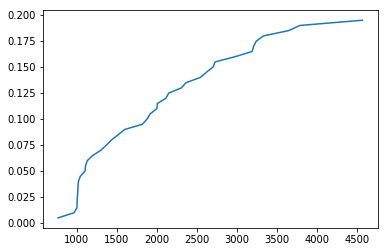

In [79]:
first_ejections_times = []
for result in results:
    if result[2]:
        first_ejections_times.append(result[2][0][-1])

first_ejections_times.sort()
fraction_ejections = np.arange(1, len(first_ejections_times) + 1) / len(results)

plt.plot(first_ejections_times, fraction_ejections).savefig("fraction_first_ejection_vs_time_eject_10_5")    

In [ ]:
[dict(sim: sim,
      intruder: intruder
    close_enocunters: [t, t, t,],
    escapes: [],
      v_escapes: [],
     kozai: [],
     orbit_crossing: []
    ), ..., ..., ..., ...,]

In [75]:
total_ejections = 0
for result in results:
    if result[2]:
        total_ejections += 1


In [6]:
39/200

0.195

In [6]:
def hill_radius(planet, star):
    return planet.a * (1 - planet.e) * np.cbrt(planet.m / (3. * star.m))

In [7]:
def calc_mutual_hill_radii_matrix(sim):
    host_star = sim.particles[0]
    
    hill_radii = np.zeros((len(sim.particles[1:]), len(sim.particles[1:])))

    # find largest mutual hill radius in sim
    for i, planet_1 in enumerate(sim.particles[1:]):
        for j, planet_2 in enumerate(sim.particles[i+2:]):
            j = j + i + 1
            print(i,j)
            mutual_hill_radius = calc_mutual_hill_radius(planet_1, planet_2, host_star.m)
            hill_radii[i][j] = mutual_hill_radius
            hill_radii[j][i] = mutual_hill_radius
    
    return hill_radii

# TEST
calc_mutual_hill_radii_matrix(sim)
    

NameError: name 'sim' is not defined

In [8]:
def calc_mutual_hill_radius(p1, p2, m_host):
    """
    Calculates mutual Hill radius of particle 1 and 2.
    """
    mutual_hill_radius = (p1.a + p2.a) / 2. * np.cbrt((p1.m + p2.m) / (3. * m_host))
    return mutual_hill_radius
    

In [9]:
def calc_escape_velocity(sim, particle):
    #sim.move_to_hel()
    
    r = np.linalg.norm(particle.xyz)
    G = sim.G
    m = sim.particles[0].m
    
    return np.sqrt(2 * G * m / r)

In [37]:
def strong_regime(resolution=100, n_trials=50):
    print("Starting strong regime simulation with resolution {}, {} trials each...".format(resolution, n_trials))
    xs = np.linspace(1, 50, resolution)
    f_eject = np.ones(resolution)
    
    for i, x in enumerate(xs):
        print("Running r_min =", x)
        eject_count = 0.
        
        # run n_trials trials detecting ejection directly after fly-by
        for j in range(n_trials):
            # get a fresh simulation
            sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
            sim = randomize_sim(sim)
            
            intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
            
            sim = simulate_fly_by(sim, intruder)
            
            sim.move_to_hel()
            for particle in sim.particles:
                v = np.linalg.norm(particle.vxyz)
                v_esc = calc_escape_velocity(sim, particle)
                if v > v_esc:
                    eject_count += 1
                    break
        print("Detected", eject_count, "ejections out of", n_trials, "trials.")
        f_eject[i] = eject_count / n_trials
        print(f_eject[i])

    
    return (xs, f_eject)            

Let's define a function to predict the stabillity of a system directly after a fly-by.

Instabillity can be defined in a number of ways. The simplest being direct ejection from the system.

This function will try to analyze the stability of a system based on direct observations of it's orbits properties.

In [10]:
def analyze_stability(sim):
    """Check stabillity of an orbit return True if (possibly) stable, False if unstable"""
    
    if check_immediate_ejection(sim) == True:
        return False
    
    elif check_orbit_crossing(sim) == True:
        return False
    
    elif check_kozai(sim) == True:
        return False
    
    elif check_AMD(sim) == True:
        return False
    
    else:
        return True
    

In [11]:
def check_immediate_ejection(sim):
    # move to Sun frame
    sim.move_to_hel()
    
    # calculate velocity of each particle and compare to escpae velocity
    for particle in sim.particles[1:]:
        v = np.linalg.norm(particle.vxyz)
        v_esc = calc_escape_velocity(sim, particle)
        if v >= v_esc:
            sim.move_to_com()
            return True
        
    sim.move_to_com()
    
    return False
    


In [19]:
sim = rebound.Simulation()
sim.add(m=1.)


In [12]:
def check_kozai(sim):
    # compare all particles
    for i, particle_1 in enumerate(sim.particles[1:]):
        for j, particle_2 in enumerate(sim.particles[i:]):
            # calculate mutual inclination. defined as difference in inclination between two orbits
            mutual_inclination = abs(particle_1.inc - particle_2.inc)
            # check if mutual inclination is between 39.2 degrees and 140.2 degrees
            if 0.684 <  mutual_inclination and mutual_inclination < 2.46:
                return True
    
    return False
            

Starting strong regime simulation with resolution 30, 100 trials each...
Running r_min = 1.0


/home/simon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


Detected 100.0 ejections out of 100 trials.
1.0
Running r_min = 2.689655172413793
Detected 100.0 ejections out of 100 trials.
1.0
Running r_min = 4.379310344827586
Detected 94.0 ejections out of 100 trials.
0.94
Running r_min = 6.068965517241379
Detected 82.0 ejections out of 100 trials.
0.82
Running r_min = 7.758620689655173
Detected 83.0 ejections out of 100 trials.
0.83
Running r_min = 9.448275862068966
Detected 69.0 ejections out of 100 trials.
0.69
Running r_min = 11.137931034482758
Detected 67.0 ejections out of 100 trials.
0.67
Running r_min = 12.827586206896552
Detected 49.0 ejections out of 100 trials.
0.49
Running r_min = 14.517241379310345
Detected 50.0 ejections out of 100 trials.
0.5
Running r_min = 16.20689655172414
Detected 44.0 ejections out of 100 trials.
0.44
Running r_min = 17.896551724137932
Detected 32.0 ejections out of 100 trials.
0.32
Running r_min = 19.586206896551726
Detected 35.0 ejections out of 100 trials.
0.35
Running r_min = 21.275862068965516
Detected 32

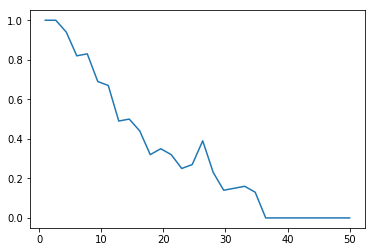

In [30]:
xs, f_eject = strong_regime(resolution=30, n_trials=100)

plt.plot(xs, f_eject)

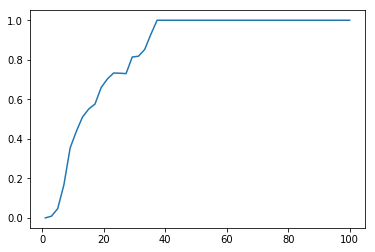

In [50]:
plt.plot(xs, 1-f_eject)

In [32]:
a = np.ones(10)
a[2] = 5
a


array([1., 1., 5., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
def randomize_sim(sim):
    sim.integrate(np.random.random()*10**3)
    return sim
    

In [60]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
simulate_fly_by(sim, intruder, visualize=True)

In [13]:
sim.particles[4].inc

0.030897078503559147

In [14]:
def mutual_rhill(p1, p2):
    """
    Calculates mutual Hill radius of particle 1 and 2.
    """
    rhill_m = (p1.a + p2.a) / 2. * ((p1.m + p2.m) / 3.)**(1/3.)
    return rhill_m


def orbit_list(simulation, period, particle, step_size):
    """
    Creates list of points on an orbit.
    """

    locations = []
    total_time = 0
#     Temporary simulation, adding sun and the particle we want the orbit from
    temp_sim = rebound.Simulation()
    temp_sim.add(simulation.particles[0])
    temp_sim.add(particle)
    
#     Integrating over exactly one orbit
    while total_time < period:
        temp_sim.integrate(temp_sim.t+step_size)
        total_time += step_size
        locations.append(temp_sim.particles[1].xyz)
    return np.array(locations)


def check_orbit_crossing(simulation):
    """
    Checks in a simulation whether any orbits cross.
    """

#     Creating and saving lists with points on orbits
    locationslist = []
    for i, particle in enumerate(simulation.particles[1:]):
        orbit = particle.calculate_orbit()
        step_size = orbit.P * orbit.rhill / (2 * np.pi * orbit.a)
        locationslist.append(orbit_list(simulation,
                                        abs(orbit.P), particle.copy(), abs(step_size)))

#     creating distance matrix
    for i, loc1 in enumerate(locationslist):
        for j, loc2 in enumerate(locationslist[i+1:]):
            dist_mat = spatial.distance_matrix(loc1, loc2)
            if dist_mat[np.where(dist_mat < mutual_rhill(simulation.particles[i+1],
                    simulation.particles[j+i+2]))].size > 0:
                # print(f"Planet {i+1} and {i+j+2} (counting from star) will collide!")
                return True

    return False


def check_immediate_ejection(sim):
    """
    Checks whether there is a planet in the simulation with v > v_escape.
    """

    # move to Sun frame
    sim.move_to_hel()

    # calculate velocity of each particle and compare to escpae velocity
    for particle in sim.particles[1:]:
        v = np.linalg.norm(particle.vxyz)
        v_esc = calc_escape_velocity(sim, particle)
        if v >= v_esc:
            sim.move_to_com()
            return True

    sim.move_to_com()
    return False


def check_kozai(sim):
    """
    Checks whether the kozai mechanism is happening in a simulation.
    """

    # compare all particles except the star
    for i, particle_1 in enumerate(sim.particles[1:]):
        for j, particle_2 in enumerate(sim.particles[i+2:]):
            # calculate mutual inclination. defined as difference in inclination between two orbits
            mutual_inclination = abs(particle_1.inc - particle_2.inc)
            # check if mutual inclination is between 39.2 degrees and 140.2 degrees
            if 0.684 <  mutual_inclination and mutual_inclination < 2.46:
                return True

    return False



def randomize_sim(sim):
    """
    Integrates simulation for any number of time between 0 and 999.
    """
    sim.integrate(random.randint(0, 999))
    return sim


def analyze_stability(sim):

    if check_immediate_ejection(sim) == True:
        print("v > v_esc")
        return False

    elif check_orbit_crossing(sim) == True:
        print("orbit crossing")
        return False

    elif check_kozai(sim) == True:
        print("Kozai mechanism activated")
        return False

    else:
        return True